In [14]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from scipy import signal

plt.rcParams["figure.figsize"]=10,5

In [3]:
def my_round(X , DX) :

    if np.log10(DX)>0 : 
        Ndecimal = 1 - np.int(np.ceil(np.abs(np.log10(DX))))
    else : 
        Ndecimal = np.int(np.ceil(np.abs(np.log10(DX))))
    
    if Ndecimal == 0 : 
        DX = np.int(np.around( DX , Ndecimal ))
        X = np.int(np.around( X , Ndecimal ))
    else : 
        DX = np.around( DX , Ndecimal )
        X = np.around( X , Ndecimal )
        
    return X , DX



def Linear(P,x) :
    return P[0] * x

####################

Loi de Jurin

####################

In [49]:
# Valeur expérimentale : 

Ech = 1./3.    # Facteur d'echelle     1cm sur la règle / taille à l'écran
rho = 792      # Masse volumique ethanol (kg.m-3)
g = 9.81    


In [50]:
ls -lrt

total 13656
-rw-r--r--@ 1 Johany  staff    28704 Apr 24 16:35 micro_LG.pdf
-rw-r--r--@ 1 Johany  staff    39308 Apr 24 16:44 micro_LL.pdf
-rw-r--r--@ 1 Johany  staff    20701 Apr 24 19:14 Barreau.pdf
-rw-r--r--@ 1 Johany  staff   905356 Apr 24 19:40 Tension_surface_Alcohol_Eau.png
-rw-r--r--@ 1 Johany  staff     7457 Apr 26 11:40 Goutte1.pdf
-rw-r--r--@ 1 Johany  staff   691275 Apr 26 14:21 the_calming_effect_of_oil_on_water.pdf
-rw-r--r--@ 1 Johany  staff    75896 Apr 27 17:01 Rayon-Courbure.pdf
-rw-r--r--@ 1 Johany  staff    63752 Apr 27 21:20 Goutte2.pdf
-rw-r--r--@ 1 Johany  staff    51513 Apr 29 14:12 Triple.pdf
-rwxr-xr-x@ 1 Johany  staff  4245382 Apr 29 16:52 Diapo.key*
-rw-r--r--@ 1 Johany  staff    12555 Apr 29 18:09 Jurin.ods
-rw-r--r--  1 Johany  staff      319 Apr 29 18:28 Jurin.csv
-rw-r--r--  1 Johany  staff      319 Apr 29 18:28 rdy2go.txt
-rw-r--r--  1 Johany  staff   141257 Apr 29 18:37 LP05.ipynb


In [51]:
# Formatage du fichier csv le cas echeant : 
catinit= open('Jurin.csv','r').read()
print (catinit)

D(mm),D_err(mm),h(mm),h_err(mm)
0.5,0.1,69.,1.
1,0.1,34.,1.
1.5,0.1,23.,1.
2.,0.1,17,1.
2.5,0.1,14.,1.
0.5,0.1,68.,1.
1,0.1,35.,1.
1.5,0.1,22.,1.
2.,0.1,18.,1.
2.5,0.1,15.,1.
0.5,0.1,70.,1.
1,0.1,36.,1.
1.5,0.1,23.,1.
2.,0.1,17.,1.
2.5,0.1,13.,1.
0.5,0.1,69.,1.
1,0.1,35.,1.
1.5,0.1,24.,1.
2.,0.1,16.,1.
2.5,0.1,14.,1.



In [52]:
catinit=catinit.replace(',',' ') #Delimiter 

cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [53]:
# Lecture du fichier Formate 
Cat = np.genfromtxt('rdy2go.txt',dtype=[('D',np.float) , ('D_err',np.float) , ('h',np.float), ('h_err',np.float)],skip_header=1)

Cat['D'] = Cat['D']*10**(-3)   # mm to m
Cat['D_err'] = Cat['D_err']*10**(-3)   # mm to m
Cat['h'] = Cat['h']*10**(-3)   # mm to m
Cat['h_err'] = Cat['h_err']*10**(-3)   # mm to m

# correction grossissement lentille de projection : 

Cat['D'] = Cat['D']*Ech
Cat['D_err'] = Cat['D_err']*Ech


In [54]:
# Préparation pour le fit : 

X = 2./Cat['D']
X_err = X * (Cat['D_err']/Cat['D'])   # f = A/B :  \sigma_f / f = sqrt( (\sigma_A / A)^2 + (\sigma_B / B)^2)


In [55]:
## Ajustement  H = A * 1/R
myModel = odr.Model(Linear)

mydata = odr.RealData(x=X,y=Cat['h'],sx=X_err ,sy=Cat['h_err'])

myodr = odr.ODR(mydata, myModel,beta0=[0.])

myoutput = myodr.run()

<IPython.core.display.Javascript object>


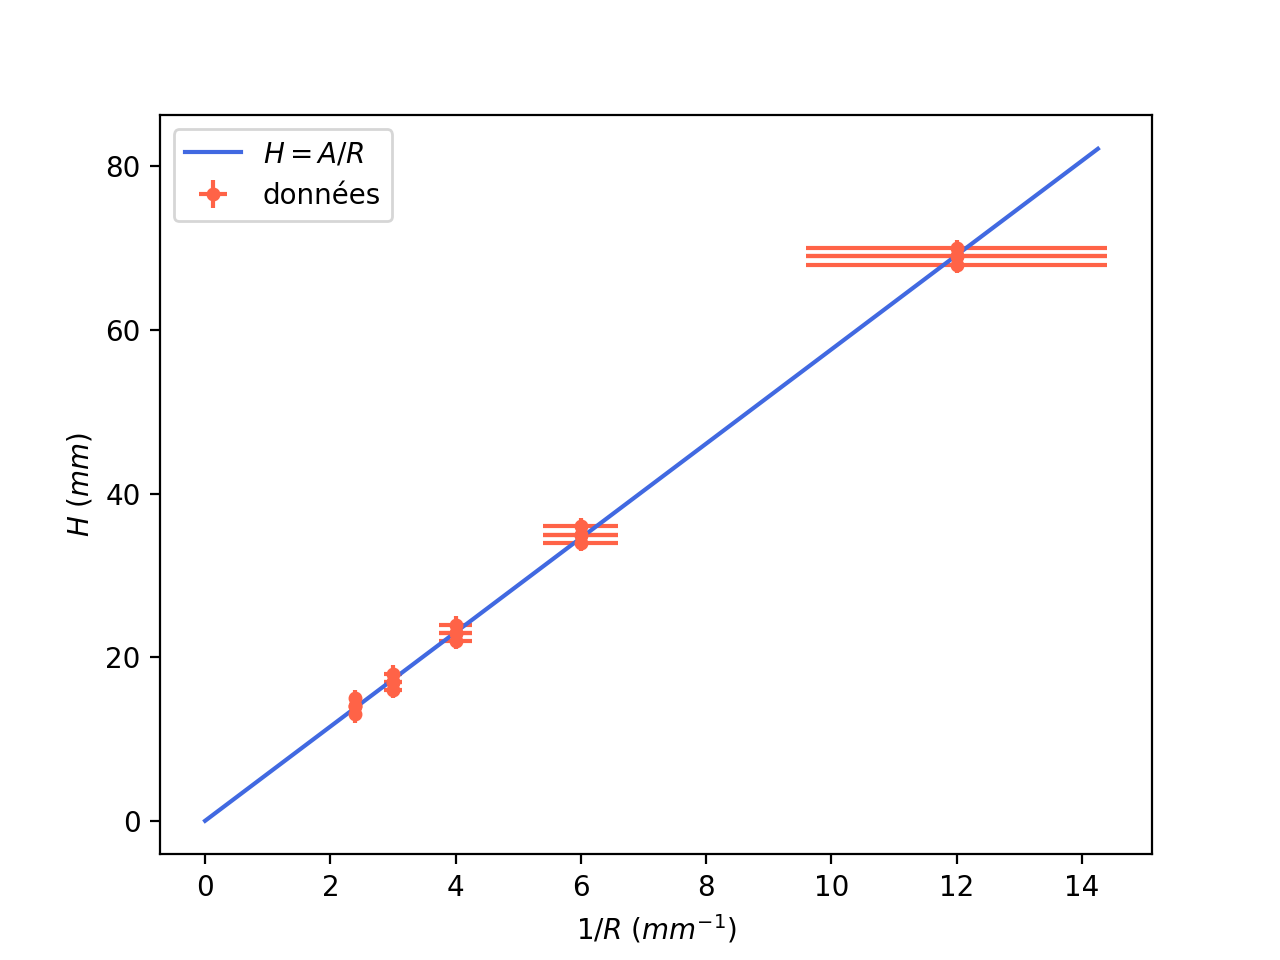

In [56]:
# Plot resultat : 

Xrange = 1.5*(np.max(X) - np.min(X))
Xmin = (np.max(X) + np.min(X))/2. - 0.5*Xrange
Xmax = (np.max(X) + np.min(X))/2. + 0.5*Xrange
Xplot = np.arange(Xmin,Xmax,Xrange/100.)

%matplotlib notebook
plt.figure()

plt.xlabel('$1/R \ (mm^{-1})$')
plt.ylabel('$H \ (mm)$')

plt.errorbar( X*10**(-3) , Cat['h']*10**(3), xerr=X_err*10**(-3), yerr=Cat['h_err']*10**(3) , color='tomato', fmt = 'o',markersize=4,label='données')
plt.plot (Xplot*10**(-3), myoutput.beta[0]*Xplot*10**(3), 'royalblue', label='$H = A/R $')


plt.legend()
plt.show()


In [58]:
# Valeur de la tension de surface : A = 2\gamma / (\rho g)

gamma = myoutput.beta[0] * rho * g / 2.

gamma_err = gamma * ( (myoutput.sd_beta[0]/myoutput.beta[0]) )

gamma_round = my_round(gamma*10**3,gamma_err*10**3) #(mN.m-1)

print("La tension de surface mesurée de l'ethanol est de : ")
print(str(gamma_round[0])+' +/- '+str(gamma_round[1])+' mN/m')

La tension de surface mesurée de l'ethanol est de : 
22.4 +/- 0.2 mN/m


################################

Methode de du Noüy

################################

In [59]:
ls -lrt

total 13728
-rw-r--r--@ 1 Johany  staff    28704 Apr 24 16:35 micro_LG.pdf
-rw-r--r--@ 1 Johany  staff    39308 Apr 24 16:44 micro_LL.pdf
-rw-r--r--@ 1 Johany  staff    20701 Apr 24 19:14 Barreau.pdf
-rw-r--r--@ 1 Johany  staff   905356 Apr 24 19:40 Tension_surface_Alcohol_Eau.png
-rw-r--r--@ 1 Johany  staff     7457 Apr 26 11:40 Goutte1.pdf
-rw-r--r--@ 1 Johany  staff   691275 Apr 26 14:21 the_calming_effect_of_oil_on_water.pdf
-rw-r--r--@ 1 Johany  staff    75896 Apr 27 17:01 Rayon-Courbure.pdf
-rw-r--r--@ 1 Johany  staff    63752 Apr 27 21:20 Goutte2.pdf
-rw-r--r--@ 1 Johany  staff    51513 Apr 29 14:12 Triple.pdf
-rwxr-xr-x@ 1 Johany  staff  4245382 Apr 29 16:52 Diapo.key*
-rw-r--r--@ 1 Johany  staff    12555 Apr 29 18:09 Jurin.ods
-rw-r--r--  1 Johany  staff      319 Apr 29 18:28 Jurin.csv
-rw-r--r--  1 Johany  staff      319 Apr 29 18:39 rdy2go.txt
-rw-r--r--  1 Johany  staff     8932 Apr 29 19:02 Nouy_Eau.ods
-rw-r--r--  1 Johany  staff      202 Apr 29 19:03 Nouy_Eau.csv
-rw-r--

In [71]:
# Formatage du fichier csv le cas echeant : 
catinit= open('Nouy_Ethanol.csv','r').read()
print (catinit)

F0(mN),F0_err(mN),F(mN),F_err(mN),D(cm),D_err(cm)
10.,1,18.,1,5.98,0.02
11.,1,19.,1,5.98,0.02
9.,1,19.,1,5.98,0.02
9.,1,18.,1,5.98,0.02
10.,1,19.,1,5.98,0.02
10.,1,18.,1,5.98,0.02
10.,1,17.,1,5.98,0.02



In [72]:
catinit=catinit.replace(',',' ') #Delimiter 

cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [73]:
# Lecture du fichier Formate 
CAT = np.genfromtxt('rdy2go.txt',dtype=[('F0',np.float) , ('F0_err',np.float) , ('F',np.float), ('F_err',np.float) , ('D',np.float), ('D_err',np.float)],skip_header=1)

CAT['F0'] = CAT['F0'] * 10**(-3)                   # mN to N 
CAT['F0_err'] = CAT['F0_err'] * 10**(-3)           # mN to N 

CAT['F'] = CAT['F'] * 10**(-3)                     # mN to N 
CAT['F_err'] = CAT['F_err'] * 10**(-3)             # mN to N 

CAT['D'] = CAT['D'] * 10**(-2)                     # cm to m
CAT['D_err'] = CAT['D_err'] * 10**(-2)             # cm to m

In [74]:
# Preparation et Moyenne des mesures

R = CAT['D']/2.
R_err = CAT['D_err']/2.

R_mean = np.mean(R)
R_mean_err = (1/len(R_err) ) * np.sqrt( np.sum(R_err**2) )

DF = CAT['F'] - CAT['F0']
DF_err = np.sqrt( CAT['F_err']**2 + CAT['F0_err']**2 )

DF_mean = np.mean(DF)

DF_mean_err = (1/len(DF_err) ) * np.sqrt( np.sum(DF_err**2) )


In [75]:
# Calcul de gamma : 

Gamma = DF_mean / (4 * np.pi * R_mean)
Gamma_err = Gamma * np.sqrt( (DF_mean_err/DF_mean)**2 + (R_mean_err/R_mean)**2 )

Gamma_round = my_round(Gamma*10**3,Gamma_err*10**3) #(mN.m-1)

print("La tension de surface mesurée est de : ")
print(str(Gamma_round[0])+' +/- '+str(Gamma_round[1])+' mN/m')

La tension de surface mesurée est de : 
22 +/- 1 mN/m
